# DS в разработке инновационных решений
# Разработал: Журавлев Александр Константинович

# Импорты и загрузка данных

In [1]:
# импортируем библиотеки
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score , KFold,TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge
from scipy.signal import butter, filtfilt
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


C:\Users\Alexander\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Загрузка данных
data = pd.read_csv('data.csv')

#  Разведывательный анализ данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Вектор Мощи                     11934 non-null  float64
 1   Скорость перехода через портал  11934 non-null  float64
 2   Приток Силы Потока              11934 non-null  float64
 3   Ритм магического ядра           11934 non-null  float64
 4   Поток Энергий                   11934 non-null  float64
 5   Сила Левого Потока              11934 non-null  float64
 6   Сила Правого Потока             11934 non-null  float64
 7   Пламя Стихий                    11934 non-null  float64
 8   Температура вдоха Истока        11934 non-null  int64  
 9   Температура выдоха Истока       11934 non-null  object 
 10  Приток давления Выдоха Истока   11934 non-null  float64
 11  Давление вдоха Истока           11934 non-null  float64
 12  Давление выдоха Истока          

### Признаки "Температура выдоха Истока" и "Древний Ветер" имеют тип Object, поскольку вместо Nan имеют текстовые записи
### Температура Вдоха истока имеет всегда одинаковое значение - 736, признак бесполезен 

## Автокорреляция целвой переменной

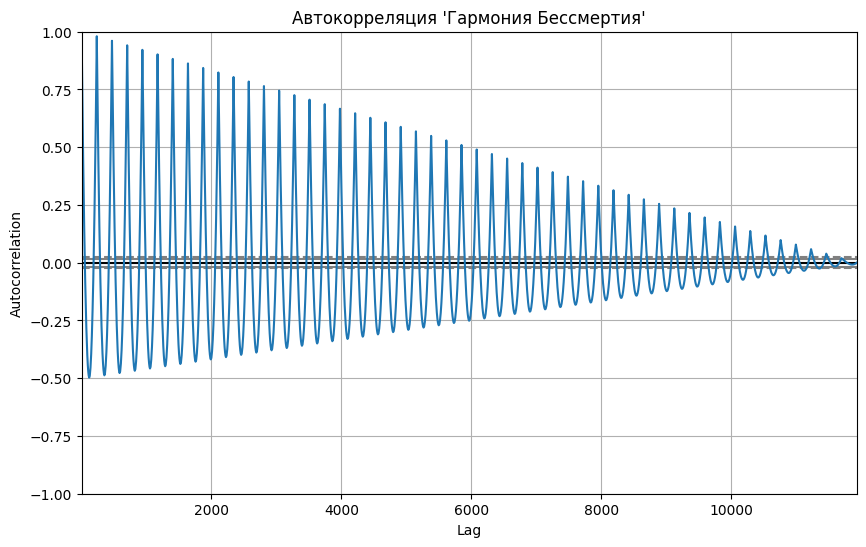

In [4]:
plt.figure(figsize=(10, 6))
autocorrelation_plot(data['Гармония Бессмертия'])
plt.title("Автокорреляция 'Гармония Бессмертия'")
plt.show()

## Сезонности и пиков нет, график затухает

In [5]:
# заменяем текстовые значения признаков на NaN
data['Температура выдоха Истока'].replace({'Исток не вернул выдох':0},inplace=True)
data['Древний Ветер'].replace({'Древний Ветер развеялся':0},inplace=True)
# удаляем столбец, в котором все значения одинаковы
data.drop(data['Температура вдоха Истока'],inplace=True)
# приводим все столбцы к единому типу данных
data=data.astype(float)

## Генерация новых признаков по совету из файла с заданием

In [6]:
data['ЛП мощность']= data['Сила Левого Потока']+data['Сила Правого Потока']
data['Совокупная мощность']=data['ЛП мощность']+data['Приток Силы Потока']
data['Общая сила ядра']=data['Ритм магического ядра']*data['Приток Силы Потока']
data['Общее давление']=data['Приток давления Выдоха Истока']+data['Давление выдоха Истока']
data['Магическая производительность']= data['Скорость перехода через портал']/data['Эмульсия Истока']
data['Эффективность ядра']=data['Общая сила ядра']/data['Эмульсия Истока']
data['Магическая мощность']=data['Эмульсия Истока']*data['Общее давление']*(data['Пламя Стихий']-data['Температура вдоха Истока']) 
data['степень износа']= data['Дыхание Истока']/data['Гармония Бессмертия'] # содержит target
data['Расхождение стабильности']=abs(data['Дыхание Истока']-data['Гармония Бессмертия']) # сожержит target
data['Баланс угасания']= data['Расхождение стабильности']/data['Скорость перехода через портал'] # содержит target

## Графический анализ данных
### Построим графики распределения для фичей, чтобы визуально оценить характер данных

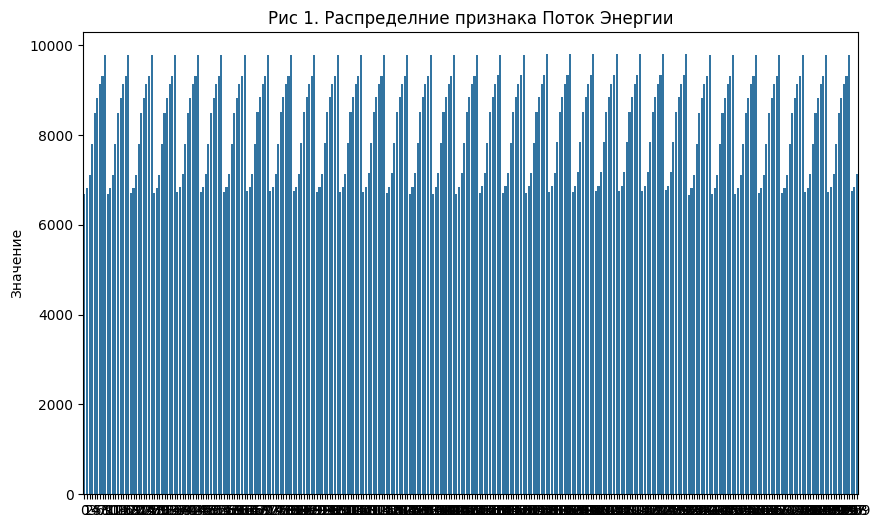

('Поток Энергий', 8200.85371717087, 1091.3133361512832, 6589.002, 9797.103)

In [7]:

plt.figure(figsize=(10, 6))
col=data.columns[4]
#sns.histplot(data[col][0:100], kde=True, color="skyblue", bins=30)
sns.barplot(data[col][0:300])
plt.ylabel("Значение")
plt.title('Рис 1. Распределние признака Поток Энергии')
plt.show()

# Calculate basic statistics for the target variable
target_mean = data[col].mean()
target_std = data[col].std()
target_min = data[col].min()
target_max = data[col].max()

col,target_mean, target_std, target_min, target_max


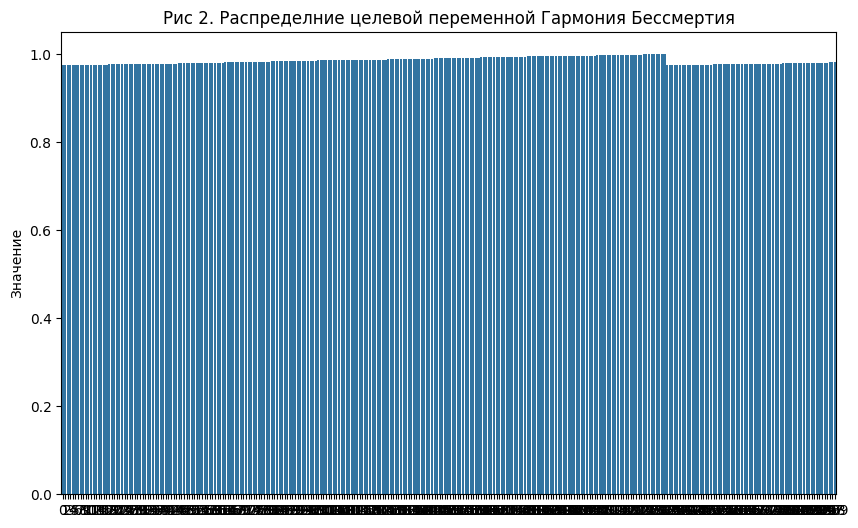

('Гармония Бессмертия', 0.9875007961116232, 0.007500124272279963, 0.975, 1.0)

In [8]:
plt.figure(figsize=(10, 6))
col=data.columns[17]
#sns.histplot(data[col][0:100], kde=True, color="skyblue", bins=30)
sns.barplot(data[col][0:300])
plt.ylabel("Значение")
plt.title('Рис 2. Распределние целевой переменной Гармония Бессмертия')
plt.show()


target_mean = data[col].mean()
target_std = data[col].std()
target_min = data[col].min()
target_max = data[col].max()

col,target_mean, target_std, target_min, target_max
# распределение таргета имеет очень низкий разброс

### Посмотрев таким образом все переменные, изменяя масштаб графиков, видим что во многих признаках присутствует периодичность, которой частота осциляций которой визуально не соответствует частоте таргета. Чтобы выяснить наверняка, проведем спектральный анализ

# Спектральный анализ

## График частотных всплесков

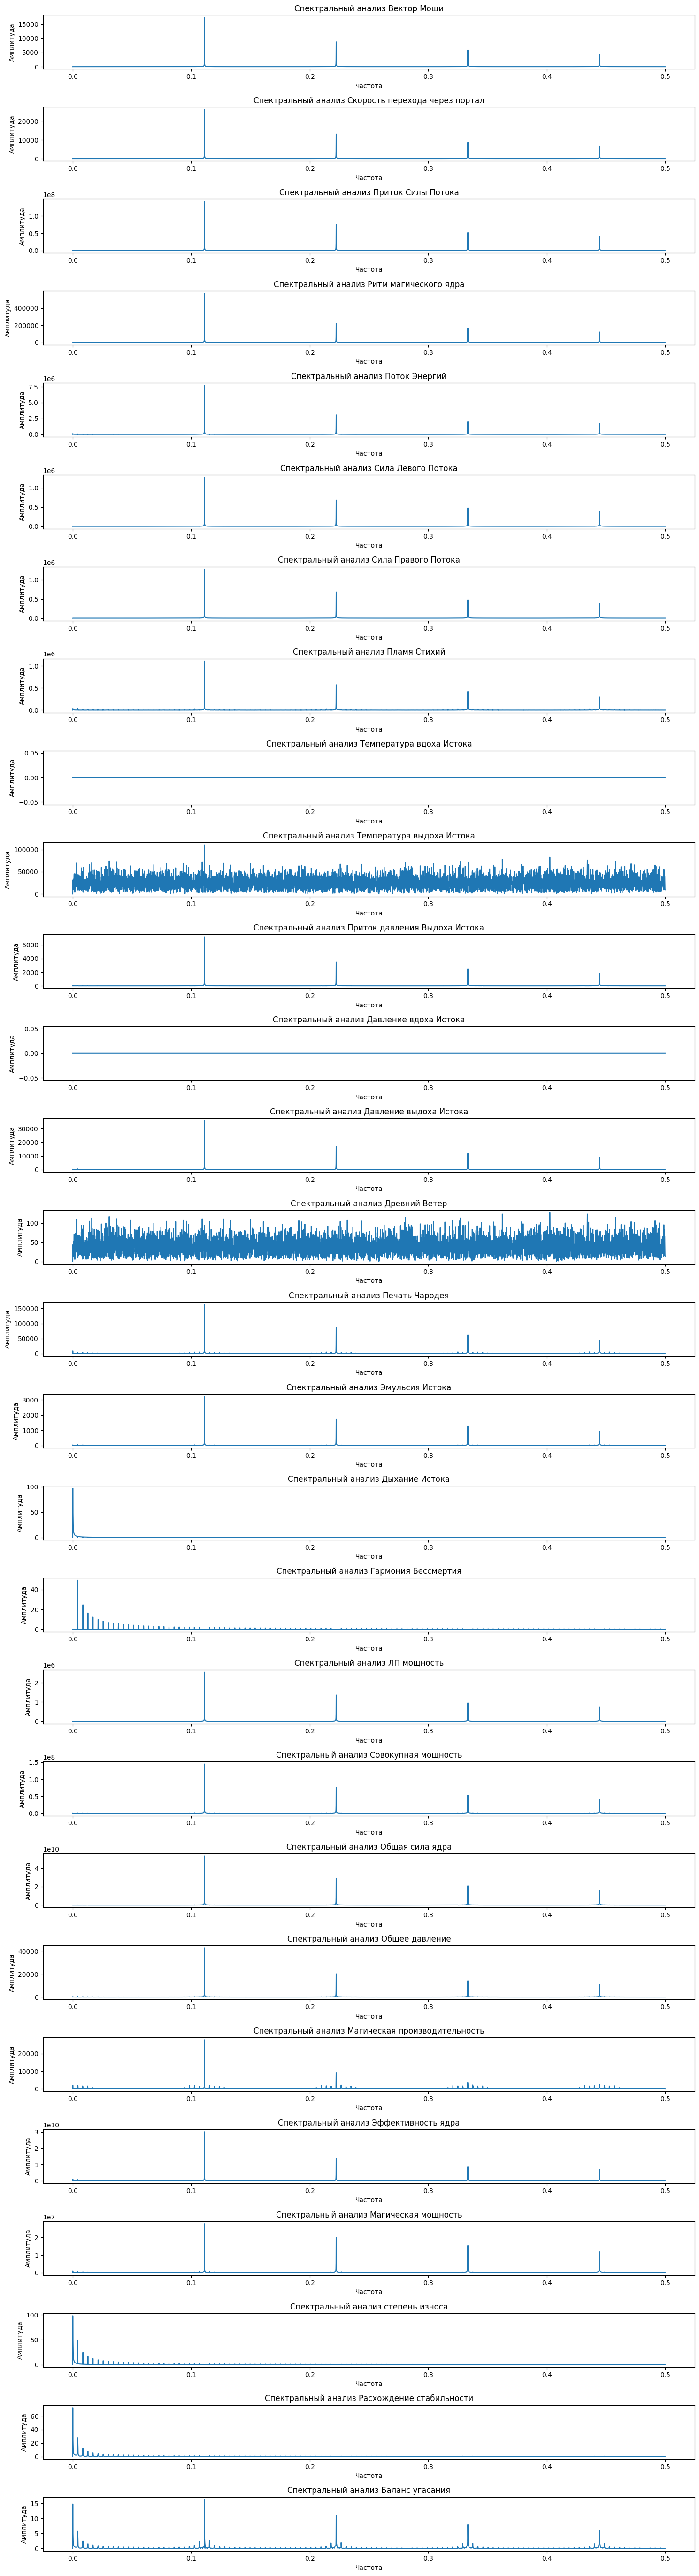

In [9]:
plt.figure(figsize=(15, 55))
for i, column in enumerate(data.columns, 1):
    spectrum = np.fft.fft(data[column] - np.mean(data[column]))
    freq = np.fft.fftfreq(len(spectrum))
    
    plt.subplot(len(data.columns), 1, i)
    plt.plot(freq[:len(freq)//2], np.abs(spectrum)[:len(freq)//2])
    plt.title(f'Спектральный анализ {column}')
    plt.xlabel('Частота')
    plt.ylabel('Амплитуда')

plt.tight_layout()
plt.show()

### Действительно, в признаках большое количество впслесков на разных частотах, в то время как таргете колебания в основном на низких частотах. Уберем высокочастотные колебания с помощью фильтра
### Для проверки эффективности сравним две линейные модели на исходных и фильтрованных данных

## Фильтр высоких частот

In [10]:

def low_pass_filter(data, cutoff=0.1, order=3):
    nyquist = 0.5  
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)
filtered_numeric_df = data.apply(lambda col: low_pass_filter(col), axis=0)

## Отбор признаков для линейной регресии
### Удаляем поочередно высокоскоррелированные признаки

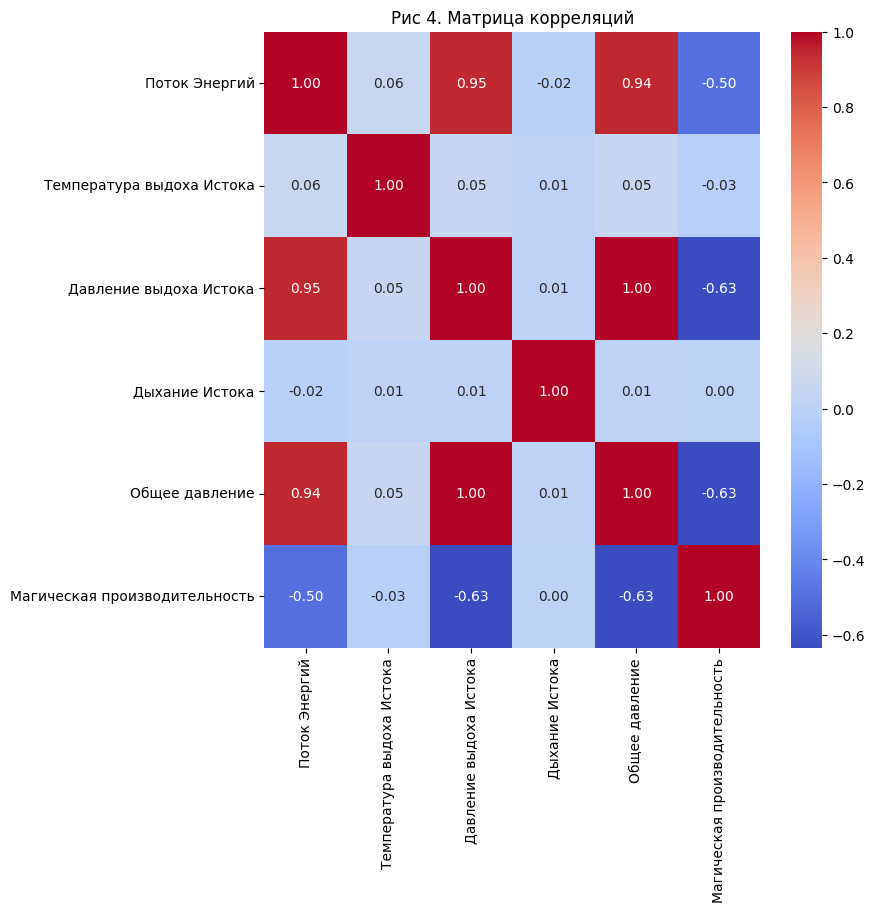

In [11]:
target='Гармония Бессмертия'
selected_features=[
        'Поток Энергий',   
       'Температура выдоха Истока', 
        'Давление выдоха Истока', 
         'Дыхание Истока',
        'Общее давление', 
        'Магическая производительность']
corr_matrix = data[selected_features].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Рис 4. Матрица корреляций')
plt.show()

### В результате отбора признаков, наилучшее значение метрики было достигнуто на данном наборе
### Несмотря на то что, остались высокоскоррелированные признаки, их удаление сильно ухудшает качество модели.
### Чтобы снизить влияние мультиколинеарности используем регуляризацию Ridge

## Сравнение регрессий на исходных и фильтрованнхы данных

In [12]:
X_orig =data[selected_features]
y_orig = data[target]
X_filt = filtered_numeric_df[selected_features]
y_filt = filtered_numeric_df[target]

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
X_filt_train, X_filt_test, y_filt_train, y_filt_test = train_test_split(X_filt, y_filt, test_size=0.2, random_state=42)


scaler_orig = StandardScaler()
scaler_filt = StandardScaler()

X_orig_train_scaled = scaler_orig.fit_transform(X_orig_train)
X_orig_test_scaled = scaler_orig.transform(X_orig_test)

X_filt_train_scaled = scaler_filt.fit_transform(X_filt_train)
X_filt_test_scaled = scaler_filt.transform(X_filt_test)

model_orig = Ridge(alpha=0.1).fit(X_orig_train_scaled, y_orig_train)
model_filt = Ridge(alpha=0.1).fit(X_filt_train_scaled, y_filt_train)

y_orig_pred = model_orig.predict(X_orig_test_scaled)
y_filt_pred = model_filt.predict(X_filt_test_scaled)

mae_orig = mean_absolute_error(y_orig_test, y_orig_pred)
r2_orig = r2_score(y_orig_test, y_orig_pred)

mae_filt = mean_absolute_error(y_filt_test, y_filt_pred)
r2_filt = r2_score(y_filt_test, y_filt_pred)
print(f"МАЕ на исходных данных:      {mae_orig:.4f}, R2 на исходных данных:  {r2_orig:.4f}")

print(f"МАЕ на фильтров. данных:     {mae_filt:.4f}, R2 на фильтр. данных:   {r2_filt:.4f}")
      

МАЕ на исходных данных:      0.0051, R2 на исходных данных:  0.3679
МАЕ на фильтров. данных:     0.0013, R2 на фильтр. данных:   0.9426


### Видим, что использование частотного фильтра позволило нам получить достаточно хорошую модель по выбранной метрике.
### Преимуществами данной модели являются: 
### 1. Интерпретируемость
### 2. Небольшое количество вычислительных ресурсов
### 3. Возможность экстраполяции
### В представленных данных высокая степень корреляции между признаками, а также могут присусттвовать нелинейные тренды или сезонность, которые линейная модель не учитывает
### Чтобы получить более точные и устойчивые результаты необходима более сложная модель   

# XGboost 
## Xgboost устойчив к мультиколинеарности, а также сможет учесть сложные нелинейные зависимости


In [13]:
selected_features=['Вектор Мощи', 'Скорость перехода через портал', 'Приток Силы Потока',
       'Ритм магического ядра', 'Поток Энергий', 'Сила Левого Потока',
       'Сила Правого Потока', 'Пламя Стихий', 'Температура вдоха Истока',
       'Температура выдоха Истока', 'Приток давления Выдоха Истока',
       'Давление вдоха Истока', 'Давление выдоха Истока', 'Древний Ветер',
       'Печать Чародея', 'Эмульсия Истока', 'Дыхание Истока',
        'ЛП мощность', 'Совокупная мощность',
       'Общая сила ядра', 'Общее давление', 'Магическая производительность',
       'Эффективность ядра', 'Магическая мощность'
       ]
selected_features1=['Давление выдоха Истока','Эффективность ядра','Ритм магического ядра','Поток Энергий','Приток Силы Потока','Сила Левого Потока',
                   'Вектор Мощи','Пламя Стихий','Магическая производительность','Эмульсия Истока',
 'Печать Чародея','Приток давления Выдоха Истока','Дыхание Истока','Совокупная мощность','Общая сила ядра',
 'Общее давление','Температура выдоха Истока','Древний Ветер']



x = data[selected_features]
y = data['Гармония Бессмертия']



x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.7,random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, 
                                                    test_size=0.5, 
                                                    random_state=12,
                                                    )




xgb_model = XGBRegressor( )
xgb_model.fit(x_train, y_train)
y_pred_xgb_test = xgb_model.predict(x_test)
y_pred_xgb_val = xgb_model.predict(x_val)

mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
mae_xgb_val = mean_absolute_error(y_test, y_pred_xgb_val)
r2_xgb_test = r2_score(y_test, y_pred_xgb_test)
r2_xgb_val = r2_score(y_val, y_pred_xgb_val)


print(f"МАЕ на test: {mae_xgb_test:.4f}, MAE на val: {mae_xgb_val:.4f}")


МАЕ на test: 0.0008, MAE на val: 0.0085


## feature importance

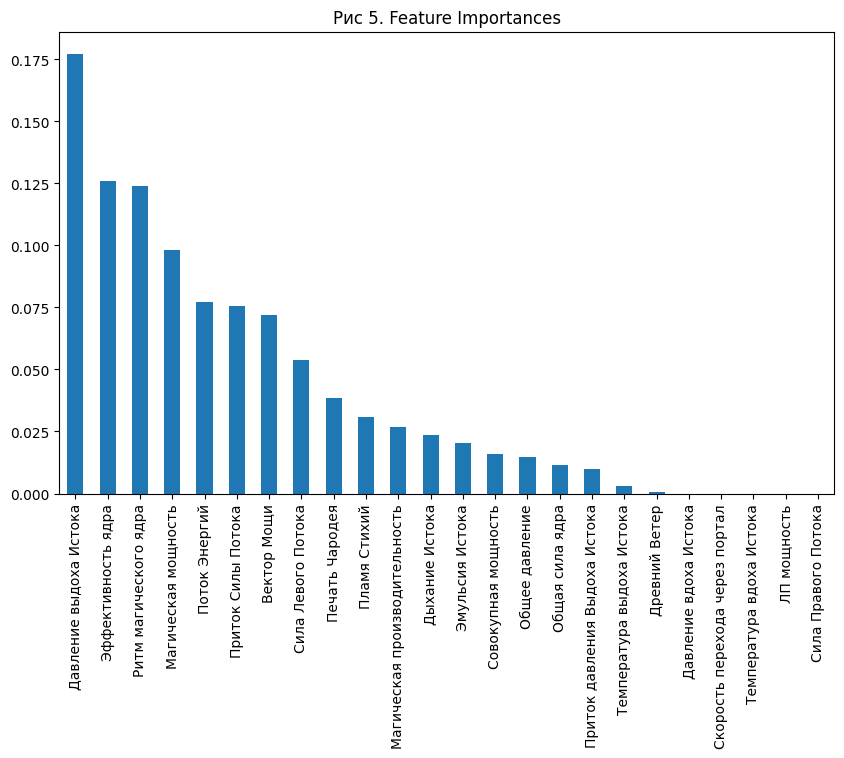

In [14]:
importance = xgb_model.feature_importances_

feature_importances = pd.Series(importance, index=x_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
new_feature_importances = feature_importances
plt.figure(figsize=(10, 6))
new_feature_importances.plot(kind="bar")
plt.title("Рис 5. Feature Importances")
plt.show()

## Из графика важности признаков видно, что большую важность для модели имеют 19 признаков, однако удаление остальных признаков приводит к ухудшению результата, поэтому будем использовать все фичи
## Также этот график можно использовать для интерпретации модели

## чтобы избежать переобучения и получить стабилтные результаты используем кросс валидацию для временного ряда

In [16]:
tscv = TimeSeriesSplit(n_splits=5)  

model = XGBRegressor()

mae_scores = []

for train_index, test_index in tscv.split(x):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    print(f"MAE на фолде: {mae:.4f}")

mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
print(f"\nСреднее MAE: {mean_mae:.4f}")
print(f"Стандартное отклонение MAE: {std_mae:.4f}")
relative_mae = mean_mae / (y.max() - y.min())
print(f'relative avg mae: {relative_mae:.4f}')

MAE на фолде: 0.0020
MAE на фолде: 0.0018
MAE на фолде: 0.0015
MAE на фолде: 0.0018
MAE на фолде: 0.0016

Среднее MAE: 0.0018
Стандартное отклонение MAE: 0.0002
relative avg mae: 0.0701


### получили неплохое значение метрики, попробуем улучшить подбором гиперпараметров

# Подбор гиперпараметров
## код закомментирован, чтобы случайно не запустить оптуну

In [ ]:
# def objective(trial):
#     
#     param = {
#         'device':'cuda',
#         'n_estimators': trial.suggest_int('n_estimators', 50, 800),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0)
#     }

#   
#     kf = TimeSeriesSplit(n_splits=5)
#     maes = []

#     for train_index, val_index in kf.split(x):
#         
#         X_train_split, X_val_split = x.iloc[train_index], x.iloc[val_index]
#         y_train_split, y_val_split = y.iloc[train_index], y.iloc[val_index]
        
#         
#         model = XGBRegressor(**param, random_state=42)
        
#         
#         pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-mae")
        
#         
#         model.fit(
#             X_train_split, y_train_split,
#             eval_set=[(X_val_split, y_val_split)],
#             eval_metric="mae",
#             early_stopping_rounds=40,
#             callbacks=[pruning_callback],
#             verbose=False
#         )
        
#         
#         y_pred = model.predict(X_val_split)
#         mae = mean_absolute_error(y_val_split, y_pred)
#         maes.append(mae)

#     
#     return np.mean(maes)

# 
# study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
# study.optimize(objective, n_trials=5000)

# 
# best_params = study.best_params

# print("Best parameters:", best_params)

## Лучшие параметры полученные в результате оптимизации через optuna:
### params={'n_estimators': 140, 
###        'max_depth': 11, 
###        'learning_rate': 0.1818368399403468, 
###        'subsample': 0.6093562087636716, 'colsample_bytree': 0.9913006243951584, 
###        'reg_alpha': 9.324530354272981e-08, 'reg_lambda': 0.0006774645792531189, 'min_child_weight': 1, 
###        'gamma': 3.9992512962705454e-07}

## Качесвто предсказаний улучшилось:
## дефолтные параметры vs оптимальные:
## Среднее MAE: 0.0018 vs 0.0015
## Стандартное отклонение MAE: 0.0002 vs 0.0001
## relative mae: 0.0701 vs 0.0599


## В целом результаты хорошие, однако mae на разных фолдах имеет разные значения, что говорит о наличии каких то неоднородностей в данных, например выбросов или структурных сдвигов, которые xgboost не учитывает. Попробуем использовать более сложную модель

# LSTM

In [17]:
target_column = data.columns.get_loc("Гармония Бессмертия")
data=data.apply(pd.to_numeric, errors='coerce')

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, target_idx, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])            
        y.append(data[i+seq_length, target_idx])  
    return np.array(X), np.array(y)


seq_length = 50  
X, y = create_sequences(scaled_data, target_column, seq_length)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.add(Dropout(0.1)) # dropout чтобы избежать переобучения
model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :target_column], 
                                                           y_pred, 
                                                           X_test[:, -1, target_column+1:]), axis=1))[:, target_column]
y_test_rescaled = scaler.inverse_transform(np.concatenate((X_test[:, -1, :target_column], 
                                                           y_test.reshape(-1, 1), 
                                                           X_test[:, -1, target_column+1:]), axis=1))[:, target_column]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print("Mean Absolute Error (MAE):", mae)

Epoch 1/20


C:\Users\Alexander\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1388 - val_loss: 0.0529
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0709 - val_loss: 0.0555
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0656 - val_loss: 0.0530
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0623 - val_loss: 0.0571
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0643 - val_loss: 0.0561
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0597 - val_loss: 0.0492
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0620 - val_loss: 0.0567
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0598 - val_loss: 0.0485
Epoch 9/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0618 - val_loss: 0.0496
Epoch 10/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0587 - val_loss: 0.0557
Epoch 11/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0599 - val_loss: 0.0435
Epoch 12/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

## используя LSTM получаем значение MAE, несколько превосходящее результаты XGboost, но весьма сильно проигрываем в скорости вычислений

## Кросс- валидация LSTM

In [18]:
target_column = data.columns.get_loc("Гармония Бессмертия")
data = data.apply(pd.to_numeric, errors='coerce')  # Преобразование данных к числовому типу


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_sequences(data, target_idx, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])            
        y.append(data[i+seq_length, target_idx])  
    return np.array(X), np.array(y)


seq_length = 50
X, y = create_sequences(scaled_data, target_column, seq_length)


tscv = TimeSeriesSplit(n_splits=5)
mae_scores = []


def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout для предотвращения переобучения
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    return model


for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

  
    model = create_model((X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),
              callbacks=[early_stopping], verbose=1)

    
    y_pred = model.predict(X_val)
    y_pred_rescaled = scaler.inverse_transform(
        np.concatenate((X_val[:, -1, :target_column], y_pred, X_val[:, -1, target_column+1:]), axis=1)
    )[:, target_column]
    y_val_rescaled = scaler.inverse_transform(
        np.concatenate((X_val[:, -1, :target_column], y_val.reshape(-1, 1), X_val[:, -1, target_column+1:]), axis=1)
    )[:, target_column]

 
    mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
    mae_scores.append(mae)
    print(f"MAE на фолде: {mae:.4f}")


print(f"\nСреднее значение MAE по всем фолдам: {np.mean(mae_scores):.4f}")

Epoch 1/20


C:\Users\Alexander\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3123 - val_loss: 0.1624
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0978 - val_loss: 0.1061
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0706 - val_loss: 0.1018
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0685 - val_loss: 0.0543
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0588 - val_loss: 0.0419
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0586 - val_loss: 0.0264
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0541 - val_loss: 0.0468
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0543 - val_loss: 0.0569
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0544 - val_loss: 0.0515
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0533 - val_loss: 0.0450
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0465 - val_loss: 0.0361
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE на фолде: 0.0007
Epoch 1/20


C:\Users\Alexander\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1930 - val_loss: 0.0467
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0782 - val_loss: 0.0531
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0641 - val_loss: 0.0400
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0562 - val_loss: 0.0225
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0524 - val_loss: 0.0297
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0502 - val_loss: 0.0261
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0508 - val_loss: 0.0404
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0454 - val_loss: 0.0479
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0443 - val_loss: 0.0243
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE на фолде: 0.0006
Epoch 1/20


C:\Users\Alexander\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1380 - val_loss: 0.0422
Epoch 2/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0621 - val_loss: 0.0400
Epoch 3/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0547 - val_loss: 0.0257
Epoch 4/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0480 - val_loss: 0.0245
Epoch 5/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0457 - val_loss: 0.0212
Epoch 6/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0442 - val_loss: 0.0525
Epoch 7/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0421 - val_loss: 0.0290
Epoch 8/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0399 - val_loss: 0.0167
Epoch 9/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0405 - val_loss: 0.0187
Epoch 10/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0368 - val_loss: 0.0169
Epoch 11/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0358 - val_loss: 0.0136
Epoch 12/20
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

C:\Users\Alexander\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1924 - val_loss: 0.0456
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0664 - val_loss: 0.0298
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0567 - val_loss: 0.0206
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0499 - val_loss: 0.0217
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0476 - val_loss: 0.0221
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0416 - val_loss: 0.0337
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0396 - val_loss: 0.0284
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0378 - val_loss: 0.0211
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE на фолде: 0.0005
Epoch 1/20


C:\Users\Alexander\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1537 - val_loss: 0.0447
Epoch 2/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0577 - val_loss: 0.0286
Epoch 3/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0505 - val_loss: 0.0156
Epoch 4/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0473 - val_loss: 0.0501
Epoch 5/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0423 - val_loss: 0.0187
Epoch 6/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0395 - val_loss: 0.0168
Epoch 7/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0364 - val_loss: 0.0161
Epoch 8/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0348 - val_loss: 0.0150
Epoch 9/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0349 - val_loss: 0.0268
Epoch 10/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0336 - val_loss: 0.0161
Epoch 11/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0346 - val_loss: 0.0158
Epoch 12/20
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.

# Заключение: 
## В данной работе были построены 3 модели разной сложности и потенциально разных сценариев парименения. Наилучший результат по выбранной метрике MAE показала модель рекуррентной нейронной сети архитектуры LSTM. Ее выбираю в качестве финальной
  
